# Malarial Diagnosis

We will give the blood report and it will detect whether it has malaria or not(Parasited or Uninfected)

We will be dealing with image data throughout.
And as it is the problem and we have to say whether it is a parasited or not, so it is
## **binary classification problem**

**1 : Uninfected
0 : Parasited**




## About Dataset

The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.
[Check out dataset by clicking here](https://www.tensorflow.org/datasets/catalog/malaria)

Feature Description :
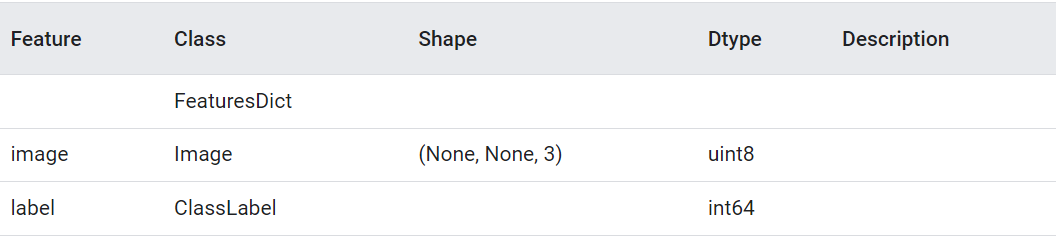

In [1]:
#Importing essential libraries
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.models import Model
from keras.layers import Layer
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from keras.losses import BinaryCrossentropy
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers  import L2, L1
from keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision,Recall,AUC

In [2]:
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete40WBJU/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# **DATA PREPARATION**

More info on [CNN Explainer](https://poloclub.github.io/cnn-explainer/)


In [4]:
def split_dataset(dataset, trainr, valr, testr):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(trainr*dataset_size))

  val_test_dataset = dataset.skip(int(trainr*dataset_size))
  val_dataset = val_test_dataset.take(int(valr*dataset_size))

  test_dataset = val_test_dataset.skip(int(valr*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [5]:
trainr = 0.8
valr = 0.1
testr = 0.1

train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], trainr, valr, testr )

# **DATA VISUALISATION**

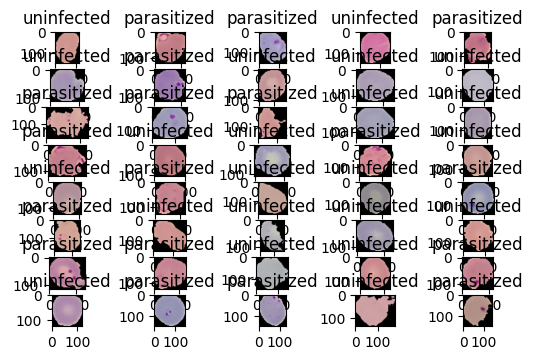

In [6]:
for i,(image,label) in enumerate(train_dataset.take(40)):
  axi = plt.subplot(10,5,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

# **DATA PREPROCESSING**

In [7]:
IMG_SIZE = 224
def image_modify(image,label):
  return tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.0,label

In [8]:
train_dataset = train_dataset.map(image_modify)
val_dataset = val_dataset.map(image_modify)
test_dataset = test_dataset.map(image_modify)


train_dataset
test_dataset
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
from os import terminal_size
train_dataset = train_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset
test_dataset
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **MODEL CREATION AND TRAINING**

In [11]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=6,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides=2),

    Conv2D(filters=16,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides=2),

    Flatten(),

    Dense(100,activation='relu'),
    BatchNormalization(),
    Dense(10,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid')

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# **FUNCTIONAL API**

Model for Extracting features : feature_extraction_model

Behaves as functional API :

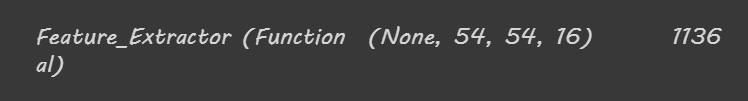

In [12]:
func_input = Input((IMG_SIZE,IMG_SIZE,3),name = 'Input Image')

x =  Conv2D(filters=6,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2,strides=2)(x)
x = Conv2D(filters=16,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2,strides=2)(x)


feature_extraction_model  = Model(func_input,output,name='Feature_Extractor')

feature_extraction_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

In [13]:
func_input = Input((IMG_SIZE,IMG_SIZE,3),name = 'Input Image')

x = feature_extraction_model(func_input)

x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation='sigmoid')(x)

lenet_model_functional = Model(func_input,func_output,name='Lenet_Model')

lenet_model_functional.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

In [14]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2)
])
feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

# **CALLABLE MODEL**

In [15]:
func_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                       

# **MODEL SUBCLASSING**

In [16]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch1 = BatchNormalization()
    self.pool1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch2 = BatchNormalization()
    self.pool2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv1(x)
    x = self.batch1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.batch2(x)
    x = self.pool2(x)

    return x

feature_subclassing = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [17]:
func_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "Input Image")

x = feature_subclassing(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                

In [18]:
class Lenet_Model(Model):
  def __init__(self):
   super(Lenet_Model,self).__init__()

   self.feature_extractor = FeatureExtractor(8,3,1,"valid","relu",2)
   self.flatten = Flatten()

   self.dense1 = Dense(100, activation = "relu")
   self.batch1 = BatchNormalization()

   self.dense2 = Dense(10, activation = "relu")
   self.batch2 = BatchNormalization()

   self.dense3 = Dense(1,activation="sigmoid")

  def call(self,x,training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch1(x)
    x = self.dense2(x)
    x = self.batch2(x)
    x = self.dense3(x)
    return x

Lenet_sub_class_model = Lenet_Model()
Lenet_sub_class_model(tf.zeros([1,224,224,3]))
Lenet_sub_class_model.summary()

Model: "lenet__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_18 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_19 (Bat  multiple                

# **CUSTOM DENSE LAYER**

- For SIGMOID and RELU activation function

In [19]:
class CustomDenseLayer(Layer):
  def __init__(self,outputv,activationF):
    super(CustomDenseLayer,self).__init__()
    self.outputv = outputv
    self.activationF = activationF

  def build(self,f_shape):
    self.weight = self.add_weight(shape = (f_shape[-1],self.outputv),initializer = "random_normal",trainable=True)
    self.biases = self.add_weight(shape = (self.outputv,),initializer = "random_normal",trainable=True)

  def call(self,input):
    ans = tf.matmul(input,self.weight) + self.biases
    if(self.activationF == "relu"):
      return tf.nn.relu(ans)
    elif(self.activationF == "sigmoid"):
      return tf.math.sigmoid(ans)
    else:
      return ans

In [53]:
dropout_Rate = 0.3

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=6,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides=2),
    Dropout(rate = dropout_Rate),

    Conv2D(filters=16,kernel_size = 3,strides = 1,padding = 'valid', activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides=2),


    Flatten(),

    Dense(100,activation= 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_Rate),

    Dense(10,activation = 'relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_Rate),

    Dense(1,activation = 'sigmoid'),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_28 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 6)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_29 (Bat  (None, 109, 109, 16)    

# **MODEL EVALUATION & TRAINING**

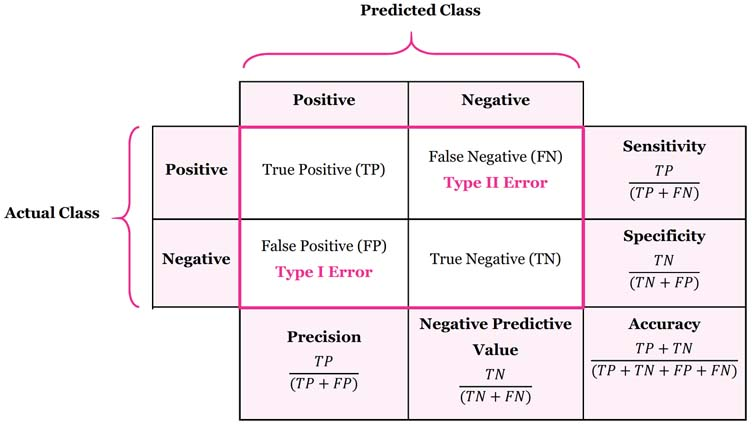

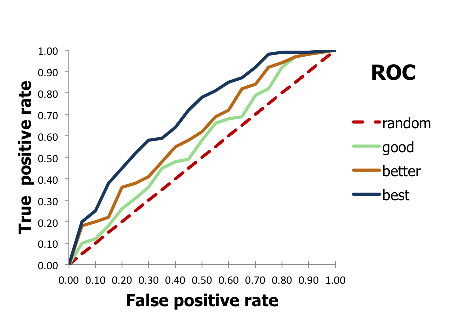

# **MODEL PERFORMANCE IMPROVEMENT TECHNIQUES**

- Callbacks
  - CustomCallbacks(to easily distinguish between lost of outputs in history)
  - Early Stopping(if the lost of gradual fallback is not observed in loss and model is behaving almost same as that of it's previous epoch, then there is no need to utilise extra epoch and you can stop training model here, as the behaviour would be almost similar now)
  - CSV Logger(To log in CSV and keep the picture clean)
  - Learning Rate Schedular (Consider you want to avoid large jumps on the graph for reaching the global minima, initially you can take big jump, then you can reduce the number of jumps using the schedular)

Custom Callback :
- on_epoch_end
- on_epoch_begin
- on_batch_begin
- on_batch_end

In [39]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  # def on_batch_end(self, batch, logs):
  #   print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

Early Stopping

In [42]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

CSV Logger

In [43]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

Learning Rate Schedular

In [49]:
def lrs(epoch, lr):

  if epoch <= 1:
    lrate = lr
  else:
    lrate = lr * tf.math.exp(-0.1)
    lrate = lrate.numpy()
  return lrate
learning_scheduler_callback = LearningRateScheduler(lrs, verbose = 1)

In [21]:
metrics = [TruePositives(name='tp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),BinaryAccuracy(name='Accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [22]:
y_true = [0,1,0,0]
y_predict = [0.6,0.51,0.94,1]
bcross = tf.keras.losses.BinaryCrossentropy(from_logits = True)
bcross(y_true,y_predict)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [23]:
# Lenet_sub_class_model.compile(optimizer = Adam(learning_rate = 0.01),loss=BinaryCrossentropy(),metrics='accuracy')

In [54]:
# lenet_model_functional.compile(optimizer = Adam(learning_rate = 0.01),loss=BinaryCrossentropy(),metrics='accuracy')
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),loss=BinaryCrossentropy(),metrics=metrics)

In [55]:
# history = lenet_model_functional.fit(train_dataset,validation_data = val_dataset,epochs = 5,verbose = 1)
# history = Lenet_sub_class_model.fit(train_dataset,validation_data = val_dataset,epochs = 5,verbose = 1)
history = lenet_model.fit(train_dataset,validation_data = val_dataset,epochs = 3,verbose = 1,callbacks=[learning_scheduler_callback,es_callback,csv_callback,LossCallback(),])



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/3
689/689 [==============================] - ETA: 0s - loss: 4.9564 - tp: 8116.0000 - tn: 8322.0000 - fn: 4298.0000 - Accuracy: 0.6628 - precision: 0.6663 - recall: 0.6538 - auc: 0.7297
 For Epoch Number 1 the model has a loss of 4.956424713134766 
689/689 [==============================] - 62s 88ms/step - loss: 4.9564 - tp: 8116.0000 - tn: 8322.0000 - fn: 4298.0000 - Accuracy: 0.6628 - precision: 0.6663 - recall: 0.6538 - auc: 0.7297 - val_loss: 6.1454 - val_tp: 995.0000 - val_tn: 720.0000 - val_fn: 396.0000 - val_Accuracy: 0.6225 - val_precision: 0.6071 - val_recall: 0.7153 - val_auc: 0.6684 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/3
689/689 [==============================] - ETA: 0s - loss: 3.0506 - tp: 6999.0000 - tn: 7157.0000 - fn: 4024.0000 - Accuracy: 0.6421 - precision: 0.6442 - recall: 0.6349 - auc: 0.6839
 For Epoch Number 2 the mo

In [28]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Epoch vs losses of Model')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train_loss','val_loss'])
# plt.show()

In [29]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Accuracy and Val accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['train_accuracy','val_accuracy'])
# plt.show()

In [30]:
lenet_model.predict(train_dataset.take(1)).shape
# Lenet_sub_class_model.predict(train_dataset.take(1)).shape

1/1 [==============================] - 0s 217ms/step


(32, 1)

# **MODEL EVALUATION**

In [31]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 15s 38ms/step - loss: 0.5018 - tp: 1352.0000 - tn: 1074.0000 - fn: 15.0000 - Accuracy: 0.8799 - precision: 0.8106 - recall: 0.9890 - auc: 0.9518


[0.501841127872467,
 1352.0,
 1074.0,
 15.0,
 0.8799419403076172,
 0.8105515837669373,
 0.9890270829200745,
 0.9517734050750732]

In [56]:
lenet_model.predict(test_dataset.take(1))[0][0]
# Lenet_sub_class_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.43680266

In [57]:
def logic_classify(x):
  if(x<0.5):
   return str('Pa')
  else:
   return str('Un')

1/1 [==============================] - 0s 36ms/step


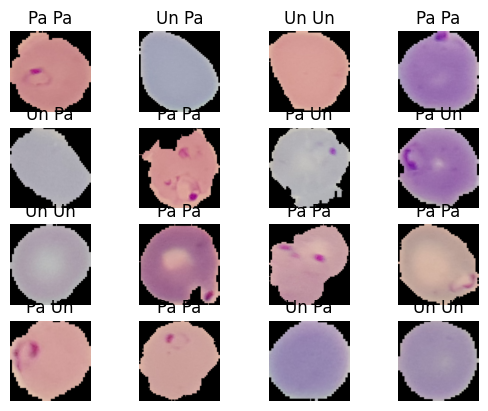

In [58]:
for i,(image,label) in enumerate(test_dataset.take(16)):
  axi = plt.subplot(4,4,i+1)
  plt.imshow(image[0])
  plt.title(str(logic_classify(label.numpy()[0])) + " " + str(logic_classify(lenet_model.predict(image)[0][0])))
  plt.axis('off')